In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn.functional as F
import glob
from torchvision.models import resnet50, ResNet50_Weights
warnings.filterwarnings('ignore')

In [ ]:
current_dir = os.getcwd()
CLEAN_DIR = os.path.join(current_dir, "content", "data", "clean")
NOISY_BASE_DIR = os.path.join(current_dir, "content", "data", "noisy")
os.makedirs(CLEAN_DIR, exist_ok=True)
os.makedirs(NOISY_BASE_DIR, exist_ok=True)

In [ ]:
zip_filename = "processed_leaf_images_224.zip"
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(CLEAN_DIR)

print(f"Extracted images to: {CLEAN_DIR}")

# Check how many images were extracted
image_files = glob.glob(os.path.join(CLEAN_DIR, "*.png"))
print(f"Found {len(image_files)} images in clean directory")

In [15]:
GAUSSIAN_DIR = os.path.join(NOISY_BASE_DIR, "gaussian")
SALT_PEPPER_DIR = os.path.join(NOISY_BASE_DIR, "salt_pepper")
POISSON_DIR = os.path.join(NOISY_BASE_DIR, "poisson")
SPECKLE_DIR = os.path.join(NOISY_BASE_DIR, "speckle")
UNIFORM_DIR = os.path.join(NOISY_BASE_DIR, "uniform")

In [16]:
GAUSSIAN_SALT_PEPPER_DIR = os.path.join(NOISY_BASE_DIR, "gaussian_salt_pepper")
GAUSSIAN_POISSON_DIR = os.path.join(NOISY_BASE_DIR, "gaussian_poisson")
GAUSSIAN_SPECKLE_DIR = os.path.join(NOISY_BASE_DIR, "gaussian_speckle")
GAUSSIAN_UNIFORM_DIR = os.path.join(NOISY_BASE_DIR, "gaussian_uniform")
SALT_PEPPER_SPECKLE_DIR = os.path.join(NOISY_BASE_DIR, "salt_pepper_speckle")
SALT_PEPPER_UNIFORM_DIR = os.path.join(NOISY_BASE_DIR, "salt_pepper_uniform")
POISSON_SPECKLE_DIR = os.path.join(NOISY_BASE_DIR, "poisson_speckle")
POISSON_UNIFORM_DIR = os.path.join(NOISY_BASE_DIR, "poisson_uniform")
SPECKLE_UNIFORM_DIR = os.path.join(NOISY_BASE_DIR, "speckle_uniform")

In [17]:
GAUSSIAN_SALT_PEPPER_SPECKLE_DIR = os.path.join(NOISY_BASE_DIR, "gaussian_salt_pepper_speckle")
GAUSSIAN_POISSON_UNIFORM_DIR = os.path.join(NOISY_BASE_DIR, "gaussian_poisson_uniform")
SALT_PEPPER_SPECKLE_UNIFORM_DIR = os.path.join(NOISY_BASE_DIR, "salt_pepper_speckle_uniform")

In [18]:
noise_dirs = [
    GAUSSIAN_DIR, SALT_PEPPER_DIR, POISSON_DIR, SPECKLE_DIR, UNIFORM_DIR,
    GAUSSIAN_SALT_PEPPER_DIR, GAUSSIAN_POISSON_DIR, GAUSSIAN_SPECKLE_DIR, GAUSSIAN_UNIFORM_DIR,
    SALT_PEPPER_SPECKLE_DIR, SALT_PEPPER_UNIFORM_DIR, POISSON_SPECKLE_DIR, POISSON_UNIFORM_DIR,
    SPECKLE_UNIFORM_DIR, GAUSSIAN_SALT_PEPPER_SPECKLE_DIR, GAUSSIAN_POISSON_UNIFORM_DIR,
    SALT_PEPPER_SPECKLE_UNIFORM_DIR
]

In [19]:
for dir_path in noise_dirs:
    os.makedirs(dir_path, exist_ok=True)


In [20]:
def add_gaussian_noise(image_array, mean=0, std=25):
    """Add Gaussian noise to image"""
    noise = np.random.normal(mean, std, image_array.shape)
    noisy_image = image_array + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def add_salt_pepper_noise(image_array, salt_prob=0.05, pepper_prob=0.05):
    """Add salt and pepper noise to image"""
    noisy_image = image_array.copy()

    # Salt noise (white pixels)
    salt_mask = np.random.random(image_array.shape[:2]) < salt_prob
    noisy_image[salt_mask] = 255

    # Pepper noise (black pixels)
    pepper_mask = np.random.random(image_array.shape[:2]) < pepper_prob
    noisy_image[pepper_mask] = 0

    return noisy_image

def add_poisson_noise(image_array):
    """Add Poisson noise to image"""
    # Convert to float, add poisson noise, then convert back
    image_float = image_array.astype(np.float32)
    noisy_image = np.random.poisson(image_float / 255.0 * 50) / 50.0 * 255.0
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def add_speckle_noise(image_array, variance=0.1):
    """Add speckle noise to image"""
    noise = np.random.normal(0, variance, image_array.shape)
    noisy_image = image_array + image_array * noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def add_uniform_noise(image_array, low=-20, high=20):
    """Add uniform noise to image"""
    noise = np.random.uniform(low, high, image_array.shape)
    noisy_image = image_array + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)


In [21]:
def process_images_with_noise():
    """Process all clean images and add different types of noise"""

    # Get all clean images
    clean_images = [f for f in os.listdir(CLEAN_DIR) if f.endswith('.png')]
    print(f"Found {len(clean_images)} clean images to process")

    for img_name in tqdm(clean_images, desc="Processing images"):
        img_path = os.path.join(CLEAN_DIR, img_name)

        try:
            # Load image
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)

            # Apply individual noise types
            gaussian_noisy = add_gaussian_noise(img_array)
            salt_pepper_noisy = add_salt_pepper_noise(img_array)
            poisson_noisy = add_poisson_noise(img_array)
            speckle_noisy = add_speckle_noise(img_array)
            uniform_noisy = add_uniform_noise(img_array)

            # Apply combination noise types
            gaussian_salt_pepper = add_salt_pepper_noise(add_gaussian_noise(img_array))
            gaussian_poisson = add_poisson_noise(add_gaussian_noise(img_array))
            gaussian_speckle = add_speckle_noise(add_gaussian_noise(img_array))
            gaussian_uniform = add_uniform_noise(add_gaussian_noise(img_array))
            salt_pepper_speckle = add_speckle_noise(add_salt_pepper_noise(img_array))
            salt_pepper_uniform = add_uniform_noise(add_salt_pepper_noise(img_array))
            poisson_speckle = add_speckle_noise(add_poisson_noise(img_array))
            poisson_uniform = add_uniform_noise(add_poisson_noise(img_array))
            speckle_uniform = add_uniform_noise(add_speckle_noise(img_array))

            # Apply triple combinations
            gaussian_salt_pepper_speckle = add_speckle_noise(add_salt_pepper_noise(add_gaussian_noise(img_array)))
            gaussian_poisson_uniform = add_uniform_noise(add_poisson_noise(add_gaussian_noise(img_array)))
            salt_pepper_speckle_uniform = add_uniform_noise(add_speckle_noise(add_salt_pepper_noise(img_array)))

            # Save individual noise types
            Image.fromarray(gaussian_noisy).save(os.path.join(GAUSSIAN_DIR, img_name))
            Image.fromarray(salt_pepper_noisy).save(os.path.join(SALT_PEPPER_DIR, img_name))
            Image.fromarray(poisson_noisy).save(os.path.join(POISSON_DIR, img_name))
            Image.fromarray(speckle_noisy).save(os.path.join(SPECKLE_DIR, img_name))
            Image.fromarray(uniform_noisy).save(os.path.join(UNIFORM_DIR, img_name))

            # Save combination noise types
            Image.fromarray(gaussian_salt_pepper).save(os.path.join(GAUSSIAN_SALT_PEPPER_DIR, img_name))
            Image.fromarray(gaussian_poisson).save(os.path.join(GAUSSIAN_POISSON_DIR, img_name))
            Image.fromarray(gaussian_speckle).save(os.path.join(GAUSSIAN_SPECKLE_DIR, img_name))
            Image.fromarray(gaussian_uniform).save(os.path.join(GAUSSIAN_UNIFORM_DIR, img_name))
            Image.fromarray(salt_pepper_speckle).save(os.path.join(SALT_PEPPER_SPECKLE_DIR, img_name))
            Image.fromarray(salt_pepper_uniform).save(os.path.join(SALT_PEPPER_UNIFORM_DIR, img_name))
            Image.fromarray(poisson_speckle).save(os.path.join(POISSON_SPECKLE_DIR, img_name))
            Image.fromarray(poisson_uniform).save(os.path.join(POISSON_UNIFORM_DIR, img_name))
            Image.fromarray(speckle_uniform).save(os.path.join(SPECKLE_UNIFORM_DIR, img_name))

            # Save triple combinations
            Image.fromarray(gaussian_salt_pepper_speckle).save(os.path.join(GAUSSIAN_SALT_PEPPER_SPECKLE_DIR, img_name))
            Image.fromarray(gaussian_poisson_uniform).save(os.path.join(GAUSSIAN_POISSON_UNIFORM_DIR, img_name))
            Image.fromarray(salt_pepper_speckle_uniform).save(os.path.join(SALT_PEPPER_SPECKLE_UNIFORM_DIR, img_name))

        except Exception as e:
            print(f"Failed to process {img_name}: {e}")

    print(f"\n----Noise addition completed!")
    print(f"Clean images: {len(clean_images)}")
    print(f"Noise directories created: {len(noise_dirs)}")
    print(f"Total noisy images generated: {len(clean_images) * len(noise_dirs)}")

In [22]:
process_images_with_noise()

Found 3000 clean images to process


Processing images: 100%|██████████| 3000/3000 [18:21<00:00,  2.72it/s]


----Noise addition completed!
Clean images: 3000
Noise directories created: 17
Total noisy images generated: 51000


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
current_dir = os.getcwd()
NOISY_BASE_DIR = os.path.join(current_dir, "content", "data", "noisy")

def load_images_and_labels_from_noise_dirs(base_dir, expected_shape=(224, 224, 3), max_images_per_dir=2500):
    """Load up to `max_images_per_dir` images per noise type and label by directory name"""
    images = []
    labels = []

    for noise_label in os.listdir(base_dir):
        noise_dir = os.path.join(base_dir, noise_label)
        if not os.path.isdir(noise_dir):
            continue

        image_files = glob.glob(os.path.join(noise_dir, "*.png"))
        image_files = image_files[:max_images_per_dir]  # Limit number of images

        print(f"Loading {len(image_files)} images from {noise_label}")

        for img_path in image_files:
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img)

                if img_array.shape != expected_shape:
                    # print(f"Skipping {img_path} due to unexpected shape: {img_array.shape}")
                    continue

                images.append(img_array)
                labels.append(noise_label)

            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load all noisy images with a cap per directory
X, y = load_images_and_labels_from_noise_dirs(NOISY_BASE_DIR, max_images_per_dir=1000)

print(f"Total images loaded: {len(X)}")
print(f"Image shape: {X[0].shape}")
print(f"Unique labels (noise types): {np.unique(y)}")

Loading 1000 images from gaussian_salt_pepper
Loading 1000 images from gaussian_speckle
Loading 1000 images from salt_pepper_uniform
Loading 1000 images from salt_pepper_speckle
Loading 1000 images from gaussian_poisson_uniform
Loading 1000 images from poisson_speckle
Loading 1000 images from uniform
Loading 1000 images from gaussian_poisson
Loading 1000 images from gaussian_uniform
Loading 1000 images from gaussian
Loading 1000 images from speckle_uniform
Loading 1000 images from gaussian_salt_pepper_speckle
Loading 1000 images from salt_pepper_speckle_uniform
Loading 1000 images from salt_pepper
Loading 1000 images from poisson_uniform
Loading 1000 images from speckle
Loading 1000 images from poisson
Total images loaded: 17000
Image shape: (224, 224, 3)
Unique labels (noise types): ['gaussian' 'gaussian_poisson' 'gaussian_poisson_uniform'
 'gaussian_salt_pepper' 'gaussian_salt_pepper_speckle' 'gaussian_speckle'
 'gaussian_uniform' 'poisson' 'poisson_speckle' 'poisson_uniform'
 'salt_

In [25]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
def extract_features(images):
    """Extract features from images for ML classifiers"""
    features = []

    for img in images:
        # Flatten image
        flat_img = img.flatten()

        # Calculate basic statistics
        mean_rgb = np.mean(img, axis=(0, 1))
        std_rgb = np.std(img, axis=(0, 1))

        # Calculate histogram features
        hist_r = np.histogram(img[:,:,0], bins=32, range=(0, 255))[0]
        hist_g = np.histogram(img[:,:,1], bins=32, range=(0, 255))[0]
        hist_b = np.histogram(img[:,:,2], bins=32, range=(0, 255))[0]

        # Combine features
        feature_vector = np.concatenate([
            mean_rgb, std_rgb, hist_r, hist_g, hist_b
        ])

        features.append(feature_vector)

    return np.array(features)

print("Extracting features for ML classifiers...")
X_features = extract_features(X)


Extracting features for ML classifiers...


In [37]:
# Apply PCA to reduce dimensionality
print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_features)

print(f"Original feature shape: {X_features.shape}")
print(f"PCA feature shape: {X_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_[:5]}")

Applying PCA for dimensionality reduction...
Original feature shape: (17000, 102)
PCA feature shape: (17000, 50)
Explained variance ratio: [0.28208188 0.23485474 0.10490831 0.07763372 0.03964893]


In [38]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (13600, 50)
Test set: (3400, 50)


In [29]:
class LeafDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # return image, label
        return image, torch.tensor(label, dtype=torch.long)

# Define transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data for deep learning
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Create datasets
train_dataset = LeafDataset(X_train_dl, y_train_dl, transform=train_transform)
test_dataset = LeafDataset(X_test_dl, y_test_dl, transform=test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Training batches: 425
Test batches: 107


In [ ]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze early layers (keep only last few layers trainable)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 2 layers
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace classifier
num_classes = len(np.unique(y_encoded))
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device
model = model.to(device)

print(f"Model moved to: {device}")
print(f"Number of classes: {num_classes}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


Model moved to: cuda
Number of classes: 17
Trainable parameters: 8,402,449
Total parameters: 11,185,233
Percentage trainable: 75.12%


In [27]:
def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    print(f"\n{'='*60}")
    print(f"Starting Transfer Learning Training")
    print(f"{'='*60}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test

        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Loss: {epoch_loss:.4f} | "
              f"Train Acc: {train_accuracy:.2f}% | "
              f"Test Acc: {test_accuracy:.2f}% | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

        scheduler.step()

    return train_losses, train_accuracies, test_accuracies


In [ ]:
train_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, num_epochs=15, learning_rate=0.001
)


Starting Transfer Learning Training
Epoch [1/15] | Loss: 1.4271 | Train Acc: 41.65% | Test Acc: 56.40% | LR: 0.001000
Epoch [2/15] | Loss: 1.1607 | Train Acc: 51.24% | Test Acc: 59.76% | LR: 0.001000
Epoch [3/15] | Loss: 1.0633 | Train Acc: 55.05% | Test Acc: 60.44% | LR: 0.001000
Epoch [4/15] | Loss: 1.0067 | Train Acc: 57.24% | Test Acc: 58.32% | LR: 0.001000
Epoch [5/15] | Loss: 0.9532 | Train Acc: 59.13% | Test Acc: 68.61% | LR: 0.001000
Epoch [6/15] | Loss: 0.9151 | Train Acc: 60.22% | Test Acc: 68.08% | LR: 0.001000
Epoch [7/15] | Loss: 0.9029 | Train Acc: 61.67% | Test Acc: 68.94% | LR: 0.001000
Epoch [8/15] | Loss: 0.7551 | Train Acc: 67.47% | Test Acc: 75.34% | LR: 0.000100
Epoch [9/15] | Loss: 0.7255 | Train Acc: 69.33% | Test Acc: 76.28% | LR: 0.000100
Epoch [10/15] | Loss: 0.7065 | Train Acc: 69.30% | Test Acc: 76.05% | LR: 0.000100
Epoch [11/15] | Loss: 0.7089 | Train Acc: 69.59% | Test Acc: 75.90% | LR: 0.000100
Epoch [12/15] | Loss: 0.6872 | Train Acc: 70.37% | Test Acc

In [ ]:
torch.save(model.state_dict(), "cnn_leaf_model.pth")

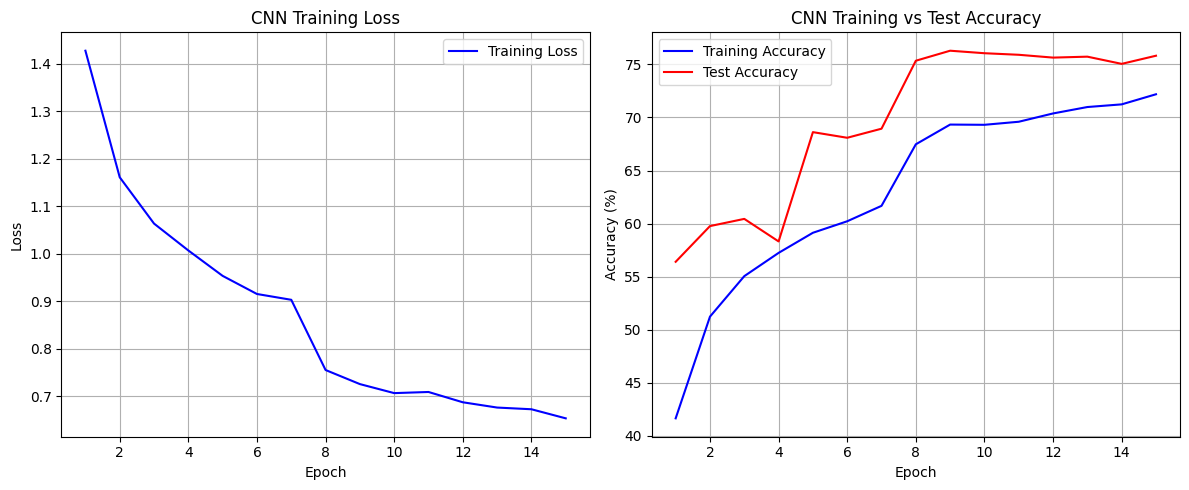

In [ ]:
plt.figure(figsize=(12, 5))

# Subplot 1: CNN Training Loss
plt.subplot(1, 2, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.title('CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: CNN Accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.title('CNN Training vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


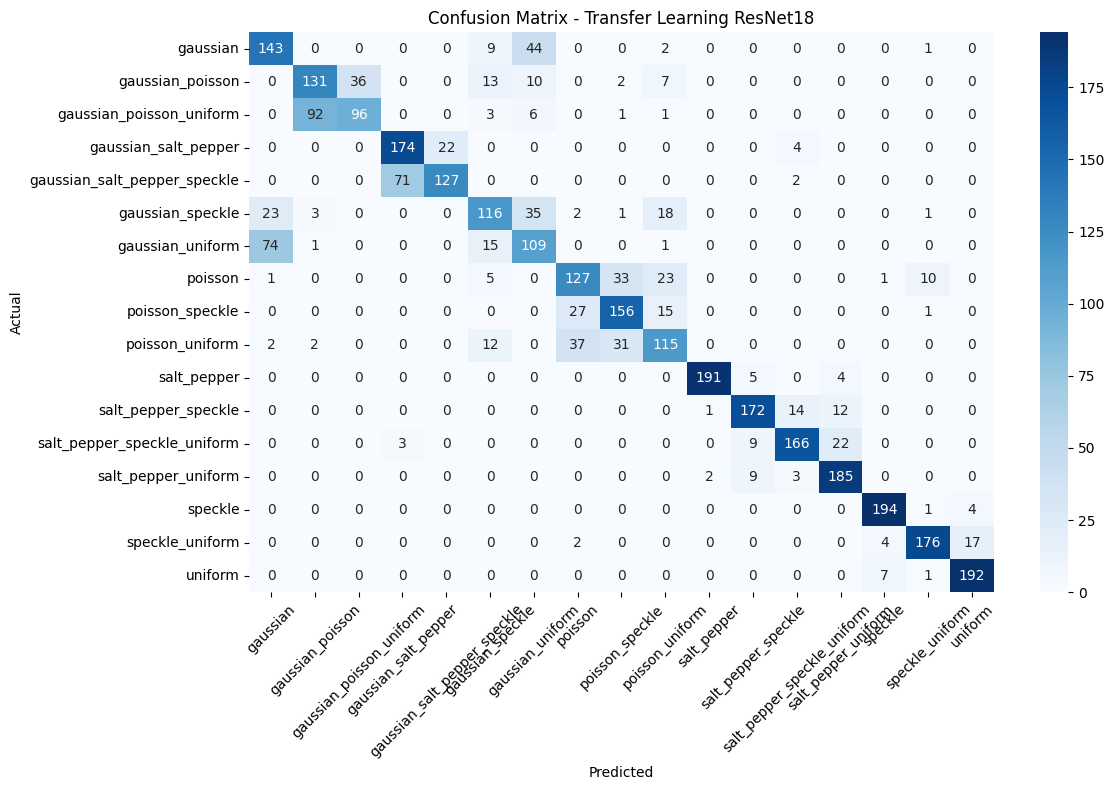

In [ ]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Transfer Learning ResNet18')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


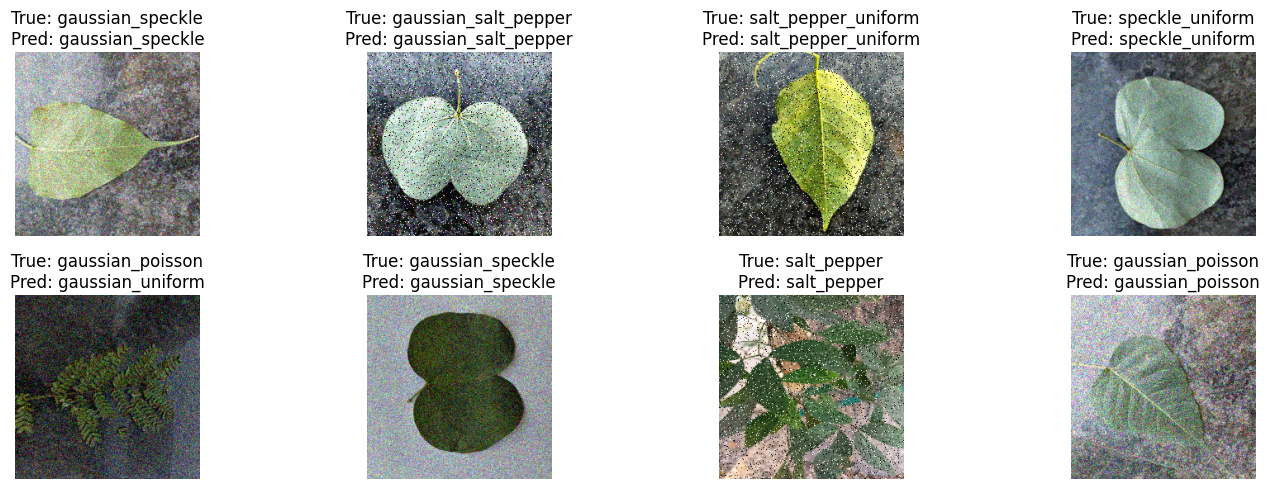

In [ ]:
# Get one batch from test loader
model.eval()
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# Move data to CPU for visualization
inputs = inputs.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Denormalize images for display
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def denormalize(img):
    img = img.permute(1, 2, 0)  # CxHxW → HxWxC
    img = img * std + mean
    return torch.clamp(img, 0, 1).numpy()

# Show N images
N = 8
plt.figure(figsize=(15, 5))
for i in range(N):
    plt.subplot(2, N//2, i+1)
    img = denormalize(inputs[i])
    plt.imshow(img)
    plt.title(f"True: {label_encoder.classes_[labels[i]]}\nPred: {label_encoder.classes_[preds[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last residual block
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace the final fully connected layer with your output classes
model.fc = nn.Linear(model.fc.in_features, 17)

# The new fc layer parameters should be learnable by default, but to be safe:
for param in model.fc.parameters():
    param.requires_grad = True

model_2 = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s]


In [30]:
train_losses, train_accuracies, test_accuracies = train_model(
    model_2, train_loader, test_loader, num_epochs=25, learning_rate=0.001
)


Starting Transfer Learning Training
Epoch [1/25] | Loss: 1.3828 | Train Acc: 43.37% | Test Acc: 58.03% | LR: 0.001000
Epoch [2/25] | Loss: 1.0343 | Train Acc: 55.99% | Test Acc: 62.18% | LR: 0.001000
Epoch [3/25] | Loss: 0.9096 | Train Acc: 60.98% | Test Acc: 71.38% | LR: 0.001000
Epoch [4/25] | Loss: 0.8411 | Train Acc: 64.32% | Test Acc: 74.18% | LR: 0.001000
Epoch [5/25] | Loss: 0.8248 | Train Acc: 64.40% | Test Acc: 75.47% | LR: 0.001000
Epoch [6/25] | Loss: 0.7781 | Train Acc: 66.15% | Test Acc: 68.82% | LR: 0.001000
Epoch [7/25] | Loss: 0.7570 | Train Acc: 66.73% | Test Acc: 76.26% | LR: 0.001000
Epoch [8/25] | Loss: 0.6377 | Train Acc: 72.74% | Test Acc: 79.62% | LR: 0.000100
Epoch [9/25] | Loss: 0.6057 | Train Acc: 74.59% | Test Acc: 79.41% | LR: 0.000100
Epoch [10/25] | Loss: 0.6003 | Train Acc: 74.25% | Test Acc: 80.53% | LR: 0.000100
Epoch [11/25] | Loss: 0.5810 | Train Acc: 74.70% | Test Acc: 81.15% | LR: 0.000100
Epoch [12/25] | Loss: 0.5595 | Train Acc: 75.85% | Test Acc

In [ ]:
torch.save(model_2.state_dict(), "resnet50_custom_17class.pth")
torch.save(model_2, "full_model.pth")

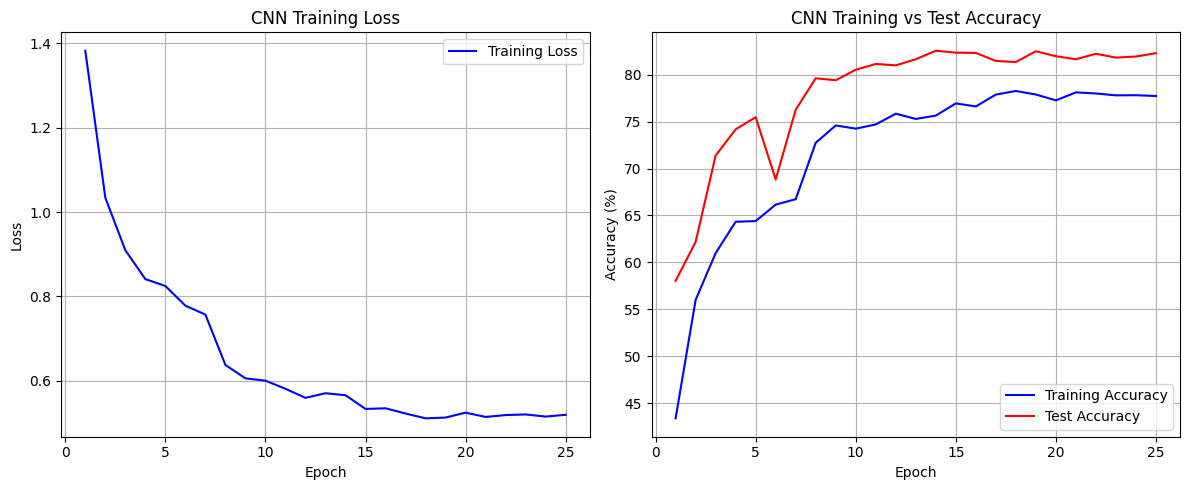

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Subplot 1: CNN Training Loss
plt.subplot(1, 2, 1)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.title('CNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: CNN Accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Test Accuracy')
plt.title('CNN Training vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


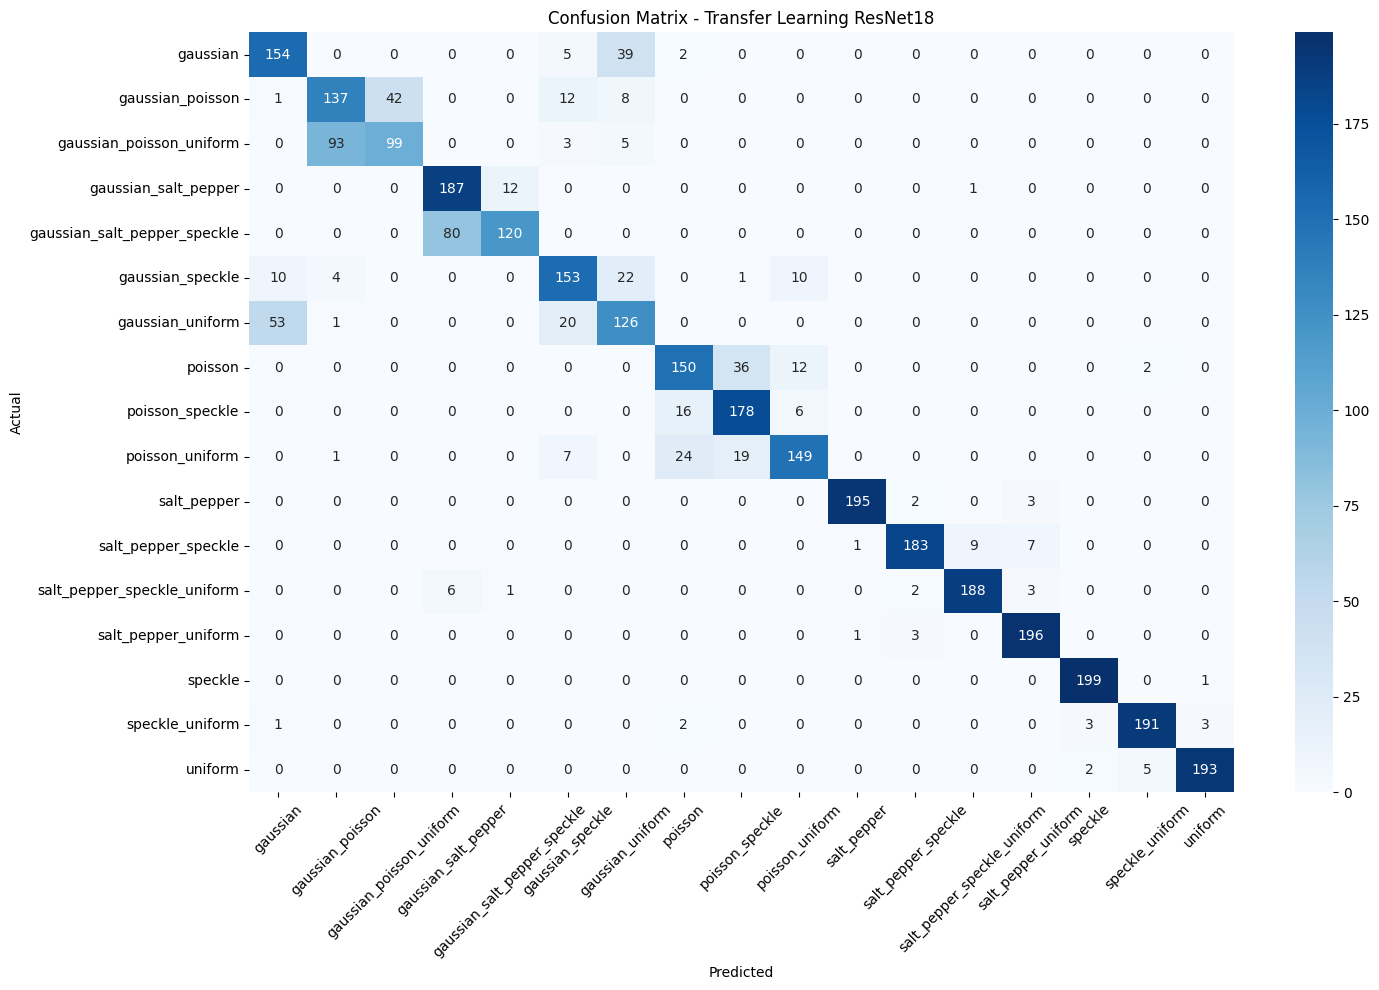

In [34]:
model_2.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_2(inputs)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
plt.figure(figsize=(15, 10))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Transfer Learning ResNet18')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


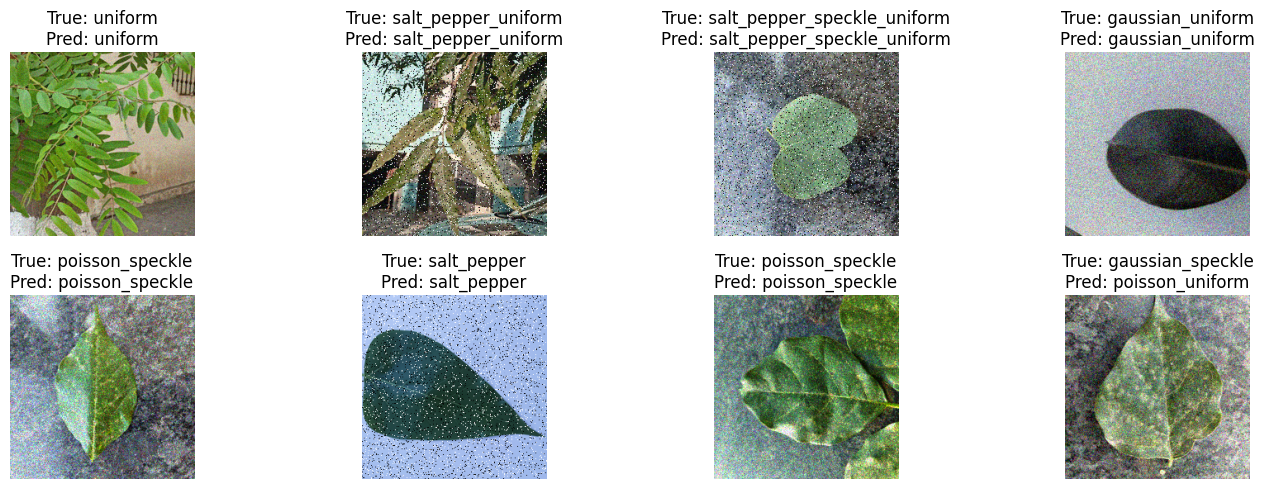

In [ ]:
# Get one batch from test loader
model.eval()
inputs, labels = next(iter(test_loader))
inputs, labels = inputs.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

# Move data to CPU for visualization
inputs = inputs.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Denormalize images for display
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

def denormalize(img):
    img = img.permute(1, 2, 0)  # CxHxW → HxWxC
    img = img * std + mean
    return torch.clamp(img, 0, 1).numpy()

# Show N images
N = 8
plt.figure(figsize=(15, 5))
for i in range(N):
    plt.subplot(2, N//2, i+1)
    img = denormalize(inputs[i])
    plt.imshow(img)
    plt.title(f"True: {label_encoder.classes_[labels[i]]}\nPred: {label_encoder.classes_[preds[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
